In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



In [29]:
def run_logreg(df):
    
    train, test = train_test_split(df, test_size=0.2)
    train_x = train.iloc[:,0:-1]
    test_x = test.iloc[:,0:-1]

    train_y = train.iloc[:,-1]
    test_y = test.iloc[:,-1]   
    
    sm = SMOTE(random_state=42)
    res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set
    
    model = LogisticRegression().fit(res_x, res_y)

    probs = model.predict_proba(test_x)
    preds = probs[:,1]

    class_names = ['Not Low Glucose', 'Low Glucose']
    disp = plot_confusion_matrix(model, 
                                 test_x, 
                                 test_y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)

In [24]:
infile = './processed/CLARITY_Export_2021-01-28_222148_min15_max45.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)
df.head()

,15,20,25,30,35,40,45,Low
5,0.309038,0.311953,0.276968,0.276968,0.276968,0.276968,0.276968,0.0
6,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.233236,0.0
7,0.309038,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.0
8,0.309038,0.309038,0.311953,0.276968,0.233236,0.233236,0.233236,0.0
9,0.309038,0.311953,0.276968,0.233236,0.183673,0.183673,0.183673,0.0


In [25]:
df['Low'].value_counts()

0.0    24961
1.0     1886
Name: Low, dtype: int64

Classes imablanced (17000+ 0 / Not Low vs 1300 1 / Low), so try SMOTE Over and Undersampling

In [12]:
train, test = train_test_split(df, test_size=0.2)
train_x = train.iloc[:,0:-1]
test_x = test.iloc[:,0:-1]

train_y = train.iloc[:,-1]
test_y = test.iloc[:,-1]

In [13]:
sm = SMOTE(random_state=42)

res_x, res_y = sm.fit_resample(train_x, train_y) ### Resample training set

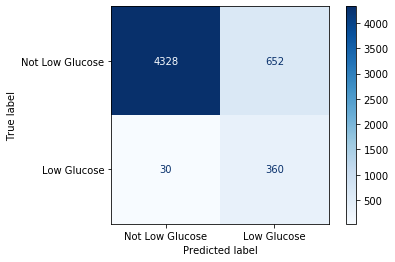

In [14]:
model = LogisticRegression().fit(res_x, res_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


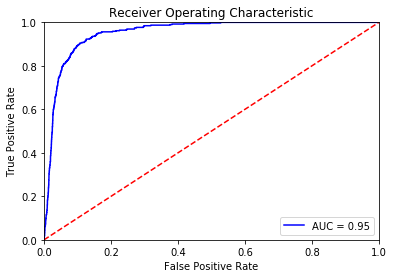

In [15]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

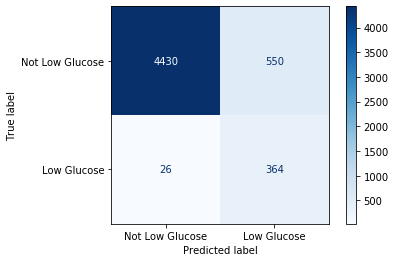

In [16]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(res_x, res_y)

disp = plot_confusion_matrix(clf, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


Undersample the majority class

In [17]:
low = df[df['Low'] == 1.0]
not_low = df[df['Low'] == 0.0].sample(n = 1886)

df_us = low.append(not_low)

In [18]:
### Train on undersampled set
train, test = train_test_split(df_us, test_size=0.2)
train_x = train.iloc[:,0:-1]
train_y = train.iloc[:,-1]

test_x = test.iloc[:,0:-1]
test_y = test.iloc[:,-1]


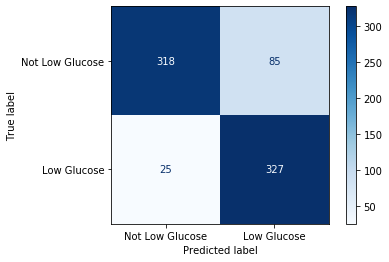

In [19]:
model = LogisticRegression().fit(train_x, train_y)

probs = model.predict_proba(test_x)
preds = probs[:,1]

class_names = ['Not Low Glucose', 'Low Glucose']
disp = plot_confusion_matrix(model, 
                             test_x, 
                             test_y,
                             display_labels=class_names,
                             cmap=plt.cm.Blues)


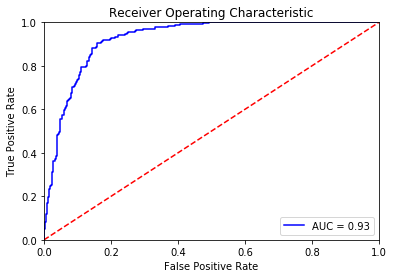

In [20]:
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

What happens if we try to extrapolate a low using data that are further back in time? (30-60 min vs. 15-45 min)

In [26]:
infile = './processed/CLARITY_Export_2021-01-28_222148_min30_max60.csv'
df = pd.read_csv(infile)
df.dropna(inplace=True)
df.head()

,30,35,40,45,50,55,60,Low
9,0.309038,0.311953,0.311953,0.311953,0.311953,0.311953,0.311953,0.0
10,0.309038,0.311953,0.276968,0.233236,0.183673,0.183673,0.183673,0.0
11,0.309038,0.311953,0.276968,0.233236,0.183673,0.163265,0.163265,0.0
12,0.309038,0.311953,0.276968,0.233236,0.183673,0.163265,0.128280,0.0
13,0.311953,0.233236,0.183673,0.163265,0.128280,0.259475,0.259475,0.0


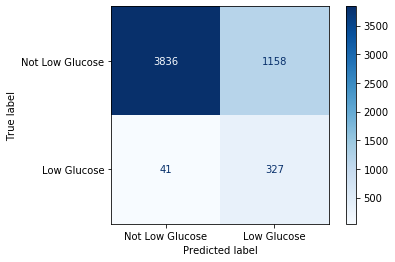

In [30]:
run_logreg(df)

- 15-45 min: False Positive rate of lows 64%
- 30-60 min: False Positive rate of lows 78%

Is this a problem? 